In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

INTRINSIC_DIM = 2

def compute_f(row):
    a = row["tangent_fraction"]
    b = row["normal_fraction"]

    # parse ambient dimension D from name: embed_dim_X_...
    name = row["name"]
    if "embed_dim_" not in name:
        return np.nan
    D = int(name.split("embed_dim_")[1].split("_")[0])

    d_t = INTRINSIC_DIM
    d_n = D - d_t
    denom = d_t * a**2 + d_n * b**2
    if denom <= 0:
        return np.nan

    return (d_t * a**2) / denom

df = pd.read_csv("outputs/full_swissroll_experiments/embed_dim_9_summary.csv")
df = df.copy()
df["D"] = df["name"].str.extract(r"embed_dim_(\d+)").astype(float)
df["f"] = df.apply(compute_f, axis=1)


In [29]:
df[0:50]

,name,use_manifold,mixed_noise,tangent_fraction,normal_fraction,num_timesteps,num_epochs,batch_size,lr,num_eval_samples,...,grid_n_u,grid_n_v,seed,device,chamfer_mean,swiss_dist_mean,chamfer_std,swiss_dist_std,D,f
0,embed_dim_4_baseline_full_normal_epochs20,True,True,0.0,1.0,1000,20,128,0.001,2000,...,200,50,0,NaN,47402.204297,47372.371094,1901.461173,1900.764064,4.0,0.000000
1,embed_dim_4_baseline_full_tangent_epochs20,True,True,1.0,0.0,1000,20,128,0.001,2000,...,200,50,0,NaN,51719.161328,51693.797266,6074.363247,6074.441970,4.0,1.000000
2,embed_dim_4_tangent_ratio_0.20_epochs20,True,True,1.0,5.0,1000,20,128,0.001,2000,...,200,50,0,NaN,153.373780,151.110853,146.843996,146.688746,4.0,0.038462
3,embed_dim_4_tangent_ratio_0.40_epochs20,True,True,2.0,5.0,1000,20,128,0.001,2000,...,200,50,0,NaN,4.023839,3.125711,1.464878,1.373300,4.0,0.137931
4,embed_dim_4_tangent_ratio_0.60_epochs20,True,True,3.0,5.0,1000,20,128,0.001,2000,...,200,50,0,NaN,2.388111,1.688284,0.189565,0.156275,4.0,0.264706
5,embed_dim_4_tangent_ratio_0.80_epochs20,True,True,4.0,5.0,1000,20,128,0.001,2000,...,200,50,0,NaN,3.205999,2.429709,0.214541,0.168458,4.0,0.390244
6,embed_dim_4_tangent_ratio_1.00_epochs20,True,True,5.0,5.0,1000,20,128,0.001,2000,...,200,50,0,NaN,3.445165,2.668333,0.143944,0.169823,4.0,0.500000
7,embed_dim_4_tangent_ratio_1.20_epochs20,True,True,6.0,5.0,1000,20,128,0.001,2000,...,200,50,0,NaN,4.196039,3.411504,0.309799,0.300874,4.0,0.590164
8,embed_dim_4_tangent_ratio_1.40_epochs20,True,True,7.0,5.0,1000,20,128,0.001,2000,...,200,50,0,NaN,4.834170,3.966769,0.331963,0.317221,4.0,0.662162
9,embed_dim_4_tangent_ratio_1.60_epochs20,True,True,8.0,5.0,1000,20,128,0.001,2000,...,200,50,0,NaN,5.044410,4.179249,0.267689,0.255555,4.0,0.719101


In [25]:
def get_isotropic_value(group):
    D = group["D"].iloc[0]
    f_iso = INTRINSIC_DIM / D
    idx = (group["f"] - f_iso).abs().idxmin()
    return group.loc[idx, "swiss_dist_mean"]


In [26]:
def get_best_value(group):
    return group["swiss_dist_mean"].min()


In [27]:
gain_rows = []

for D, g in df.dropna(subset=["f", "swiss_dist_mean"]).groupby("D"):
    iso = get_isotropic_value(g)
    best = get_best_value(g)

    gain_rows.append({
        "D": int(D),
        "iso_swiss": iso,
        "best_swiss": best,
        "gain": iso / best
    })

gain_df = pd.DataFrame(gain_rows).sort_values("D")


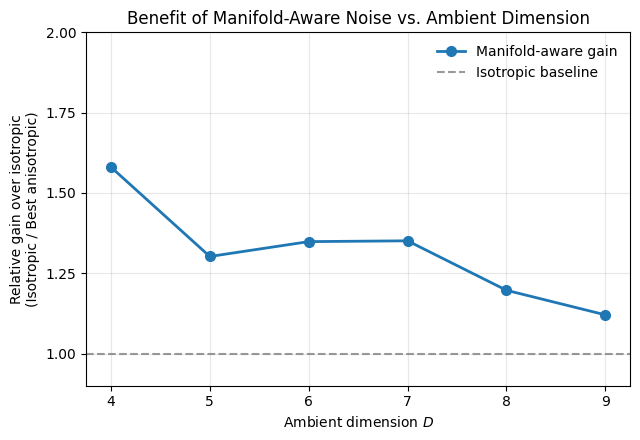

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gain_vs_dimension(gain_df):
    """
    gain_df must have columns:
        - D : ambient dimension
        - gain : isotropic_metric / best_anisotropic_metric
    """

    plt.figure(figsize=(6.5, 4.5))

    # Main curve
    plt.plot(
        gain_df["D"],
        gain_df["gain"],
        marker="o",
        linewidth=2,
        markersize=7,
        label="Manifold-aware gain"
    )

    # Reference line: isotropic == best
    plt.axhline(
        y=1.0,
        linestyle="--",
        color="gray",
        linewidth=1.5,
        alpha=0.8,
        label="Isotropic baseline"
    )

    # Axis labels
    plt.xlabel("Ambient dimension $D$")
    plt.ylabel("Relative gain over isotropic\n(Isotropic / Best anisotropic)")

    # Axis limits for clarity
    plt.ylim(0.9, 2.0)

    # Ticks
    plt.xticks(gain_df["D"])
    plt.yticks(np.arange(1.0, 2.05, 0.25))

    # Title
    plt.title("Benefit of Manifold-Aware Noise vs. Ambient Dimension")

    # Grid + legend
    plt.grid(True, alpha=0.3)
    plt.legend(frameon=False)

    plt.tight_layout()
    plt.show()

plot_gain_vs_dimension(gain_df)